<a href="https://colab.research.google.com/github/DirkStulgies/mlwtSportsPrediction/blob/main/Sports.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score

In [16]:
### uploaded this one into my one of my public repositories, as this will be an outdated version of the spi dataset (this is just for coding practicing)
df = pd.read_csv("https://raw.githubusercontent.com/lxndrshm/DBminutes/main/spi_matches.csv")
import requests as rq
from io import BytesIO

#url = "https://raw.githubusercontent.com/lxndrshm/DBminutes/main/spi_matches.csv"
#data = rq.get(url).content
#df = pd.read_csv(BytesIO(data))
#df = df.drop(df.columns[[0]], axis=1)
dataset = df.copy()
dataset.head()

,season,date,league_id,league,team1,team2,spi1,spi2,prob1,prob2,probtie,proj_score1,proj_score2,importance1,importance2,score1,score2,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2
0,2016,2016-07-09,7921,FA Women's Super League,Liverpool Women,Reading,51.56,50.42,0.4389,0.2767,0.2844,1.39,1.05,NaN,NaN,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2016,2016-07-10,7921,FA Women's Super League,Arsenal Women,Notts County Ladies,46.61,54.03,0.3572,0.3608,0.2819,1.27,1.28,NaN,NaN,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2016,2016-07-10,7921,FA Women's Super League,Chelsea FC Women,Birmingham City,59.85,54.64,0.4799,0.2487,0.2714,1.53,1.03,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2016,2016-07-16,7921,FA Women's Super League,Liverpool Women,Notts County Ladies,53.00,52.35,0.4289,0.2699,0.3013,1.27,0.94,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2016,2016-07-17,7921,FA Women's Super League,Chelsea FC Women,Arsenal Women,59.43,60.99,0.4124,0.3157,0.2719,1.45,1.24,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
### dropping all the coloums we dont need. We can also drop more coloums like importance
#df = df.drop(["xg1","xg2","nsxg1", "nsxg2","adj_score1", "adj_score2","spi1", "spi2", "proj_score1", "proj_score2"], axis = 1)
df = df.drop(["adj_score1", "adj_score2","proj_score1", "proj_score2", "season", "date", "league_id", "team1", "team2"], axis = 1)
#df = df.drop(["adj_score1", "adj_score2","proj_score1", "proj_score2", "season", "date", "league_id", "team1", "team2"], axis = 1)
#creating a back-up copy 
#copydf = df
### drop NA´s (keep in mind, that this drops all unplayed games for now, e.g the games we wanna predict in the future)
df = df.dropna()

In [18]:
df.dtypes

league          object
spi1           float64
spi2           float64
prob1          float64
prob2          float64
probtie        float64
importance1    float64
importance2    float64
score1         float64
score2         float64
xg1            float64
xg2            float64
nsxg1          float64
nsxg2          float64
dtype: object

In [20]:
df["maxValueB"] = df.iloc[:, [2,3,4]].max(axis=1)
df

,league,spi1,spi2,prob1,prob2,probtie,importance1,importance2,score1,score2,xg1,xg2,nsxg1,nsxg2,maxValue,maxValueB
10,French Ligue 1,51.16,85.68,0.0463,0.8380,0.1157,32.4,67.7,0.0,1.0,0.97,0.63,0.43,0.45,0.8380,85.68
11,French Ligue 1,68.85,56.48,0.5714,0.1669,0.2617,53.7,22.9,2.0,2.0,2.45,0.77,1.75,0.42,0.5714,56.48
12,Barclays Premier League,53.57,66.81,0.3459,0.3621,0.2921,38.1,22.2,2.0,1.0,0.85,2.77,0.17,1.25,0.3621,66.81
13,Barclays Premier League,58.98,59.74,0.4482,0.2663,0.2854,36.5,29.1,0.0,1.0,1.24,1.84,1.71,1.56,0.4482,59.74
14,Barclays Premier League,56.32,60.35,0.4380,0.2692,0.2927,33.9,32.5,1.0,1.0,1.40,0.55,1.13,1.06,0.4380,60.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50049,German Bundesliga,72.67,62.83,0.5306,0.2036,0.2659,33.0,19.8,4.0,0.0,2.99,0.64,1.97,0.58,0.5306,62.83
50050,German Bundesliga,67.70,67.62,0.4052,0.3257,0.2691,10.6,18.2,2.0,3.0,2.61,3.36,1.48,1.85,0.4052,67.62
50051,German Bundesliga,55.82,60.17,0.3847,0.3193,0.2960,47.5,22.5,2.0,0.0,0.66,0.77,1.10,0.52,0.3847,60.17
50052,Barclays Premier League,57.98,72.21,0.2883,0.4443,0.2674,37.8,12.3,0.0,2.0,0.64,1.64,0.82,1.73,0.4443,72.21


In [21]:
# create a list of our conditions
conditions = [
    (df['maxValue'] <= 0.1),
    (df['maxValue'] > 0.1) & (df['maxValue'] <= 0.2),
    (df['maxValue'] > 0.2) & (df['maxValue'] <= 0.3),
    (df['maxValue'] > 0.3) & (df['maxValue'] <= 0.4),
    (df['maxValue'] > 0.4) & (df['maxValue'] <= 0.5),
    (df['maxValue'] > 0.5) & (df['maxValue'] <= 0.6),
    (df['maxValue'] > 0.6) & (df['maxValue'] <= 0.7),
    (df['maxValue'] > 0.7) & (df['maxValue'] <= 0.8),
    (df['maxValue'] > 0.8) & (df['maxValue'] <= 0.9),
    (df['maxValue'] > 0.9)
    ]

# create a list of the values we want to assign for each condition
values = ['0.05', '0.15', '0.25', '0.35', '0.45', '0.55', '0.65', '0.75', '0.85', '0.95']

# create a new column and use np.select to assign values to it using our lists as arguments
df['tier'] = np.select(conditions, values)

# display updated DataFrame
df.head()

,league,spi1,spi2,prob1,prob2,probtie,importance1,importance2,score1,score2,xg1,xg2,nsxg1,nsxg2,maxValue,maxValueB,tier
10,French Ligue 1,51.16,85.68,0.0463,0.8380,0.1157,32.4,67.7,0.0,1.0,0.97,0.63,0.43,0.45,0.8380,85.68,0.85
11,French Ligue 1,68.85,56.48,0.5714,0.1669,0.2617,53.7,22.9,2.0,2.0,2.45,0.77,1.75,0.42,0.5714,56.48,0.55
12,Barclays Premier League,53.57,66.81,0.3459,0.3621,0.2921,38.1,22.2,2.0,1.0,0.85,2.77,0.17,1.25,0.3621,66.81,0.35
13,Barclays Premier League,58.98,59.74,0.4482,0.2663,0.2854,36.5,29.1,0.0,1.0,1.24,1.84,1.71,1.56,0.4482,59.74,0.45
14,Barclays Premier League,56.32,60.35,0.4380,0.2692,0.2927,33.9,32.5,1.0,1.0,1.40,0.55,1.13,1.06,0.4380,60.35,0.45


In [22]:
### Create a new result coloumn
# create a list of our conditions
conditions = [
    (df['score1'] > df["score2"]),
    (df['score1'] < df["score2"]),
    (df['score1'] == df["score2"])
    ]
# create a list of the values we want to assign for each condition
values = ['0', '2', '1']

# create a new column and use np.select to assign values to it using our lists as arguments
df['result'] = np.select(conditions, values)

# display updated DataFrame
df.head()

,league,spi1,spi2,prob1,prob2,probtie,importance1,importance2,score1,score2,xg1,xg2,nsxg1,nsxg2,maxValue,maxValueB,tier,result
10,French Ligue 1,51.16,85.68,0.0463,0.8380,0.1157,32.4,67.7,0.0,1.0,0.97,0.63,0.43,0.45,0.8380,85.68,0.85,2
11,French Ligue 1,68.85,56.48,0.5714,0.1669,0.2617,53.7,22.9,2.0,2.0,2.45,0.77,1.75,0.42,0.5714,56.48,0.55,1
12,Barclays Premier League,53.57,66.81,0.3459,0.3621,0.2921,38.1,22.2,2.0,1.0,0.85,2.77,0.17,1.25,0.3621,66.81,0.35,0
13,Barclays Premier League,58.98,59.74,0.4482,0.2663,0.2854,36.5,29.1,0.0,1.0,1.24,1.84,1.71,1.56,0.4482,59.74,0.45,2
14,Barclays Premier League,56.32,60.35,0.4380,0.2692,0.2927,33.9,32.5,1.0,1.0,1.40,0.55,1.13,1.06,0.4380,60.35,0.45,1


In [23]:
dct = {'prob1': '0', 'prob2': '2', 'probtie': '1'}
df["proj_result"] = df[["prob1", "prob2", "probtie"]].idxmax(axis=1).map(dct)
#df["highest"] = max(df[["prob1", "prob2", "probtie"]])

In [24]:
### Create a new result coloumn
# create a list of our conditions
conditions = [
    (df['result'] > df["proj_result"]),
    (df['result'] < df["proj_result"]),
    (df['result'] == df["proj_result"])
    ]
# create a list of the values we want to assign for each condition
values = ['False', 'False', 'Correct']

# create a new column and use np.select to assign values to it using our lists as arguments
df['acc'] = np.select(conditions, values)

# display updated DataFrame
df

,league,spi1,spi2,prob1,prob2,probtie,importance1,importance2,score1,score2,xg1,xg2,nsxg1,nsxg2,maxValue,maxValueB,tier,result,proj_result,acc
10,French Ligue 1,51.16,85.68,0.0463,0.8380,0.1157,32.4,67.7,0.0,1.0,0.97,0.63,0.43,0.45,0.8380,85.68,0.85,2,2,Correct
11,French Ligue 1,68.85,56.48,0.5714,0.1669,0.2617,53.7,22.9,2.0,2.0,2.45,0.77,1.75,0.42,0.5714,56.48,0.55,1,0,False
12,Barclays Premier League,53.57,66.81,0.3459,0.3621,0.2921,38.1,22.2,2.0,1.0,0.85,2.77,0.17,1.25,0.3621,66.81,0.35,0,2,False
13,Barclays Premier League,58.98,59.74,0.4482,0.2663,0.2854,36.5,29.1,0.0,1.0,1.24,1.84,1.71,1.56,0.4482,59.74,0.45,2,0,False
14,Barclays Premier League,56.32,60.35,0.4380,0.2692,0.2927,33.9,32.5,1.0,1.0,1.40,0.55,1.13,1.06,0.4380,60.35,0.45,1,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50049,German Bundesliga,72.67,62.83,0.5306,0.2036,0.2659,33.0,19.8,4.0,0.0,2.99,0.64,1.97,0.58,0.5306,62.83,0.55,0,0,Correct
50050,German Bundesliga,67.70,67.62,0.4052,0.3257,0.2691,10.6,18.2,2.0,3.0,2.61,3.36,1.48,1.85,0.4052,67.62,0.45,2,0,False
50051,German Bundesliga,55.82,60.17,0.3847,0.3193,0.2960,47.5,22.5,2.0,0.0,0.66,0.77,1.10,0.52,0.3847,60.17,0.35,0,0,Correct
50052,Barclays Premier League,57.98,72.21,0.2883,0.4443,0.2674,37.8,12.3,0.0,2.0,0.64,1.64,0.82,1.73,0.4443,72.21,0.45,2,2,Correct


In [25]:
df["result"] = df['result'].astype(str).astype(int)
df["tier"] = df['tier'].astype(str).astype(float)
df["proj_result"] = df['proj_result'].astype(str).astype(int)
df.dtypes

league          object
spi1           float64
spi2           float64
prob1          float64
prob2          float64
probtie        float64
importance1    float64
importance2    float64
score1         float64
score2         float64
xg1            float64
xg2            float64
nsxg1          float64
nsxg2          float64
maxValue       float64
maxValueB      float64
tier           float64
result           int64
proj_result      int64
acc             object
dtype: object

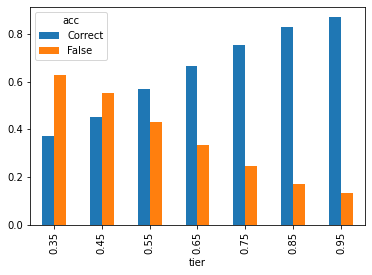

In [44]:
df.groupby('tier')['acc'].value_counts(normalize=True, sort=False).unstack().plot(kind='bar');


In [ ]:
### reduces our dataframe to Bundesliga, would be nice to include 2. Bundesliga aswell. I did not know how to inculde that aswell. Also League_id seems off somehow.
#df = df[df['league'] == 'German Bundesliga']
df = df.drop(["score1", "score2"], axis = 1)
df = df.drop(["prob1", "prob2","probtie", "xg1", "xg2", "nsxg1", "nsxg2"], axis = 1)

In [ ]:
df

,spi1,spi2,importance1,importance2,result
10,51.16,85.68,32.4,67.7,2
11,68.85,56.48,53.7,22.9,1
12,53.57,66.81,38.1,22.2,0
13,58.98,59.74,36.5,29.1,2
14,56.32,60.35,33.9,32.5,1
...,...,...,...,...,...
50049,72.67,62.83,33.0,19.8,0
50050,67.70,67.62,10.6,18.2,2
50051,55.82,60.17,47.5,22.5,0
50052,57.98,72.21,37.8,12.3,2


In [27]:
df['acc'].value_counts(normalize=True)
#y = df['result']

Correct    0.5141
False      0.4859
Name: acc, dtype: float64

In [ ]:
from sklearn import preprocessing
import pandas as pd
#df = preprocessing.normalize(df, axis=0)
#df = pd.DataFrame(df)
#df.head()

In [ ]:
df_copy = df
df["proj_result"] = df['proj_result'].astype(str).astype(int)

KeyError: ignored

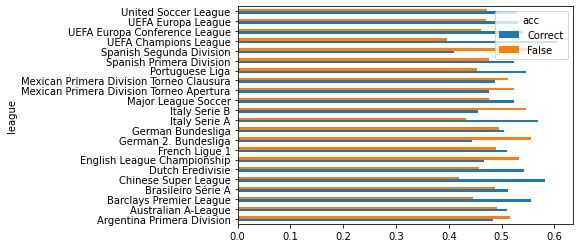

In [62]:
#df.groupby("league")["acc"].value_counts()(normalize=True).to_frame()
df.groupby('league')['acc'].value_counts(normalize=True, sort=True, ascending=True).unstack().plot(kind='barh');
dfplot = df.groupby('league')['acc'].value_counts(normalize=True).unstack()

In [65]:
df.groupby('league')['acc'].value_counts(normalize=True, sort=True)

league                                    acc    
Argentina Primera Division                False      0.515734
                                          Correct    0.484266
Australian A-League                       Correct    0.509346
                                          False      0.490654
Barclays Premier League                   Correct    0.554950
                                          False      0.445050
Brasileiro Série A                        Correct    0.512195
                                          False      0.487805
Chinese Super League                      Correct    0.581197
                                          False      0.418803
Dutch Eredivisie                          Correct    0.542222
                                          False      0.457778
English League Championship               False      0.533638
                                          Correct    0.466362
French Ligue 1                            Correct    0.509916
                    

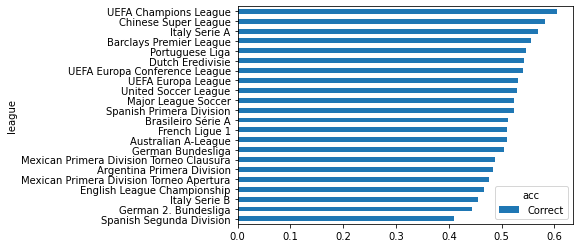

In [67]:
#dfplot = dfplot.drop(["False"], axis = 1)
dfplot = dfplot.sort_values("Correct")
dfplot.plot(kind="barh")

In [ ]:
df.groupby('result')['acc'].value_counts(normalize=True, sort=False)

In [ ]:
df.groupby('proj_result')['acc'].value_counts(normalize=True, sort=False)

In [ ]:
df["imp_dif"] = df["importance1"] - df["importance2"]
df["spi_dif"] = df["spi1"] - df["spi2"]
df

,spi1,spi2,importance1,importance2,result,imp_dif,spi_dif
10,51.16,85.68,32.4,67.7,2,-35.3,-34.52
11,68.85,56.48,53.7,22.9,1,30.8,12.37
12,53.57,66.81,38.1,22.2,0,15.9,-13.24
13,58.98,59.74,36.5,29.1,2,7.4,-0.76
14,56.32,60.35,33.9,32.5,1,1.4,-4.03
...,...,...,...,...,...,...,...
50049,72.67,62.83,33.0,19.8,0,13.2,9.84
50050,67.70,67.62,10.6,18.2,2,-7.6,0.08
50051,55.82,60.17,47.5,22.5,0,25.0,-4.35
50052,57.98,72.21,37.8,12.3,2,25.5,-14.23


In [ ]:
df = df.drop(["spi1", "spi2", "importance1", "importance2"], axis = 1)

In [ ]:
X = df.drop(['result'], axis=1)
y = df['result']
#X = df = df.iloc[: , :-1]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [ ]:
model = Sequential()
model.add(Dense(units=4, activation='relu', input_dim=len(X_train.columns)))
model.add(Dense(units=10, activation='relu'))
model.add(Dense(units=3, activation='softmax'))

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy', "sparse_categorical_accuracy"]) #sparse categorical crossentropy

In [ ]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)    #, batch_size=32) #validation data

Epoch 1/10
613/613 [==============================] - 2s 3ms/step - loss: 1.8086 - accuracy: 0.4388 - sparse_categorical_accuracy: 0.4388 - val_loss: 1.0601 - val_accuracy: 0.4568 - val_sparse_categorical_accuracy: 0.4568
Epoch 2/10
613/613 [==============================] - 1s 2ms/step - loss: 1.0239 - accuracy: 0.4801 - sparse_categorical_accuracy: 0.4801 - val_loss: 1.0211 - val_accuracy: 0.4954 - val_sparse_categorical_accuracy: 0.4954
Epoch 3/10
613/613 [==============================] - 1s 2ms/step - loss: 1.0135 - accuracy: 0.4954 - sparse_categorical_accuracy: 0.4954 - val_loss: 1.0170 - val_accuracy: 0.4958 - val_sparse_categorical_accuracy: 0.4958
Epoch 4/10
613/613 [==============================] - 1s 2ms/step - loss: 1.0104 - accuracy: 0.4955 - sparse_categorical_accuracy: 0.4955 - val_loss: 1.0139 - val_accuracy: 0.4958 - val_sparse_categorical_accuracy: 0.4958
Epoch 5/10
613/613 [==============================] - 1s 2ms/step - loss: 1.0086 - accuracy: 0.4971 - sparse_cat

In [ ]:
print("echte werte für team 1 sieg")
print(model(np.array([[0.9635,0.6995,0.685,0.273]])))
print("echte werte für team 2 sieg")
print(model(np.array([[0.6995,0.9635,0.273,0.685]])))
print("echte werte für unentschieden")
print(model(np.array([[0.5411,0.5257,0.288,0.247]])))
print("fiktive werte für team 2 sieg")
print(model(np.array([[0.1111,0.9999,0.111,0.999]])))

echte werte für team 1 sieg
tf.Tensor([[0.43687198 0.3172462  0.24588183]], shape=(1, 3), dtype=float32)
echte werte für team 2 sieg
tf.Tensor([[0.4299575  0.3105153  0.25952712]], shape=(1, 3), dtype=float32)
echte werte für unentschieden
tf.Tensor([[0.42777082 0.30719694 0.2650323 ]], shape=(1, 3), dtype=float32)
fiktive werte für team 2 sieg
tf.Tensor([[0.4201668  0.2942456  0.28558764]], shape=(1, 3), dtype=float32)


In [ ]:
print("echte werte für team 1 sieg")
print(model(np.array([[50, 50]])))
print("echte werte für team 2 sieg")
print(model(np.array([[-50, -50]])))
print("echte werte für unentschieden")
print(model(np.array([[1, 1]])))
print("fiktive werte für team 2 sieg")
print(model(np.array([[-150 , -150]])))

echte werte für team 1 sieg
tf.Tensor([[0.9245685  0.05135999 0.02407159]], shape=(1, 3), dtype=float32)
echte werte für team 2 sieg
tf.Tensor([[0.02862316 0.06572188 0.9056549 ]], shape=(1, 3), dtype=float32)
echte werte für unentschieden
tf.Tensor([[0.44707778 0.3036944  0.24922775]], shape=(1, 3), dtype=float32)
fiktive werte für team 2 sieg
tf.Tensor([[1.07471315e-05 2.13782696e-04 9.99775469e-01]], shape=(1, 3), dtype=float32)
